# Data Preparation

In [1]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV

In [2]:
# Constants for retrieving the data and setting the data types
csv_file = 'StaterData.csv'
dtypes = {
    'Date received': str,
    'Product': "category",
    'Sub-product': "category",
    'Issue': "category",
    'Sub-issue':"category",
    'Consumer complaint narrative':str,
    'Company public response':str,
    'Company':"category",
    'State':"category",
    'ZIP code':str,
    'Tags':"category",
    'Consumer consent provided?':str,
    'Submitted via':"category",
    'Date sent to company':str,
    'Company response to consumer':str,
    'Timely response?':str,
    'Consumer disputed?':str,
    'Complaint ID':int,
    'Clean consumer complaint':str
}

#### Read csv data
There is a column named 'Clean consumer complaint'. The text from 'Consumer complaint narrative' is already cleaned by the complaintCleaner

In [4]:
# Read data from csv file
data = pd.read_csv(csv_file, dtype=dtypes)
print(data.head())
print(data.info())
df = data[['Clean consumer complaint', 'Issue']].copy()

   Complaint ID                                              Issue  \
0       6697855                     Trouble during payment process   
1       5832311  Applying for a mortgage or refinancing an exis...   
2       2787647                     Trouble during payment process   
3       6589323                     Trouble during payment process   
4       6633594                         Struggling to pay mortgage   

                        Consumer complaint narrative  \
0  I closed on my house XX/XX/XXXX, XXXX  payment...   
1  XXXX and XXXX Mortgage payments were marked as...   
2  XXXX XXXX XXXX On XX/XX/XXXX, I called 21st mo...   
3  Loancare through XXXX XXXX XXXX' is negligentl...   
4  In XXXX of XXXX, I received a Loan Modificatio...   

                            Clean consumer complaint  
0  close house payment due xxxxoriginal loan serv...  
1  mortgage payment mark late account covid forbe...  
2  call st mortgage home finance father name titl...  
3  loancare negligentl

In [5]:
# Check value counts of each issue
df['Issue'].value_counts()

Trouble during payment process                                                      34122
Struggling to pay mortgage                                                          17598
Loan servicing, payments, escrow account                                            14721
Loan modification,collection,foreclosure                                            10789
Applying for a mortgage or refinancing an existing mortgage                         10556
Closing on a mortgage                                                                7454
Application, originator, mortgage broker                                             3746
Settlement process and costs                                                         2249
Incorrect information on your report                                                 1432
Credit decision / Underwriting                                                       1289
Problem with a credit reporting company's investigation into an existing problem      627
Improper u

# Modelling (Multinomial Logistic Regression)

The Issue will be predicted based of the consumer complaint that is already cleaned. So the independent variable x is 'Clean consumer complaint' and the dependent variable y is 'Issue'. <br>
All contained categories will be saved in the variable cat_issue to label them in the visualisation and classification report.

In [9]:
# get all categories of y for the results
cat_issue = y.cat.categories

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df['Clean consumer complaint'], df['Issue'], test_size=0.3, random_state=2)

In [10]:
# Vectorize the data with tfidf
vectorizer = TfidfVectorizer(stop_words='english', token_pattern=r'\b[a-zA-Z]+\b')
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

Best estimator according the gridsearch is: LogisticRegression(C=1, multi_class='multinomial', n_jobs=4, random_state=2, solver='saga'). max_iter default value is 100<br><br>
But running with the default parameter will convey the following message: 'ConvergenceWarning: The max_iter was reached which means the coef_ did not converge'. That is why max_iter=1000 is used, as 100 is too little.

In [12]:
# Create multinomial logistic regression
logregression = LogisticRegression(C=1, multi_class='multinomial', n_jobs=4, random_state=2, solver='saga', max_iter=1000)

# Fit and predict
logregression.fit(X_train_tfidf, y_train)
y_pred = logregression.predict(X_test_tfidf)

accuracy:0.5741023196695265
f1 score:0.5477947530503394


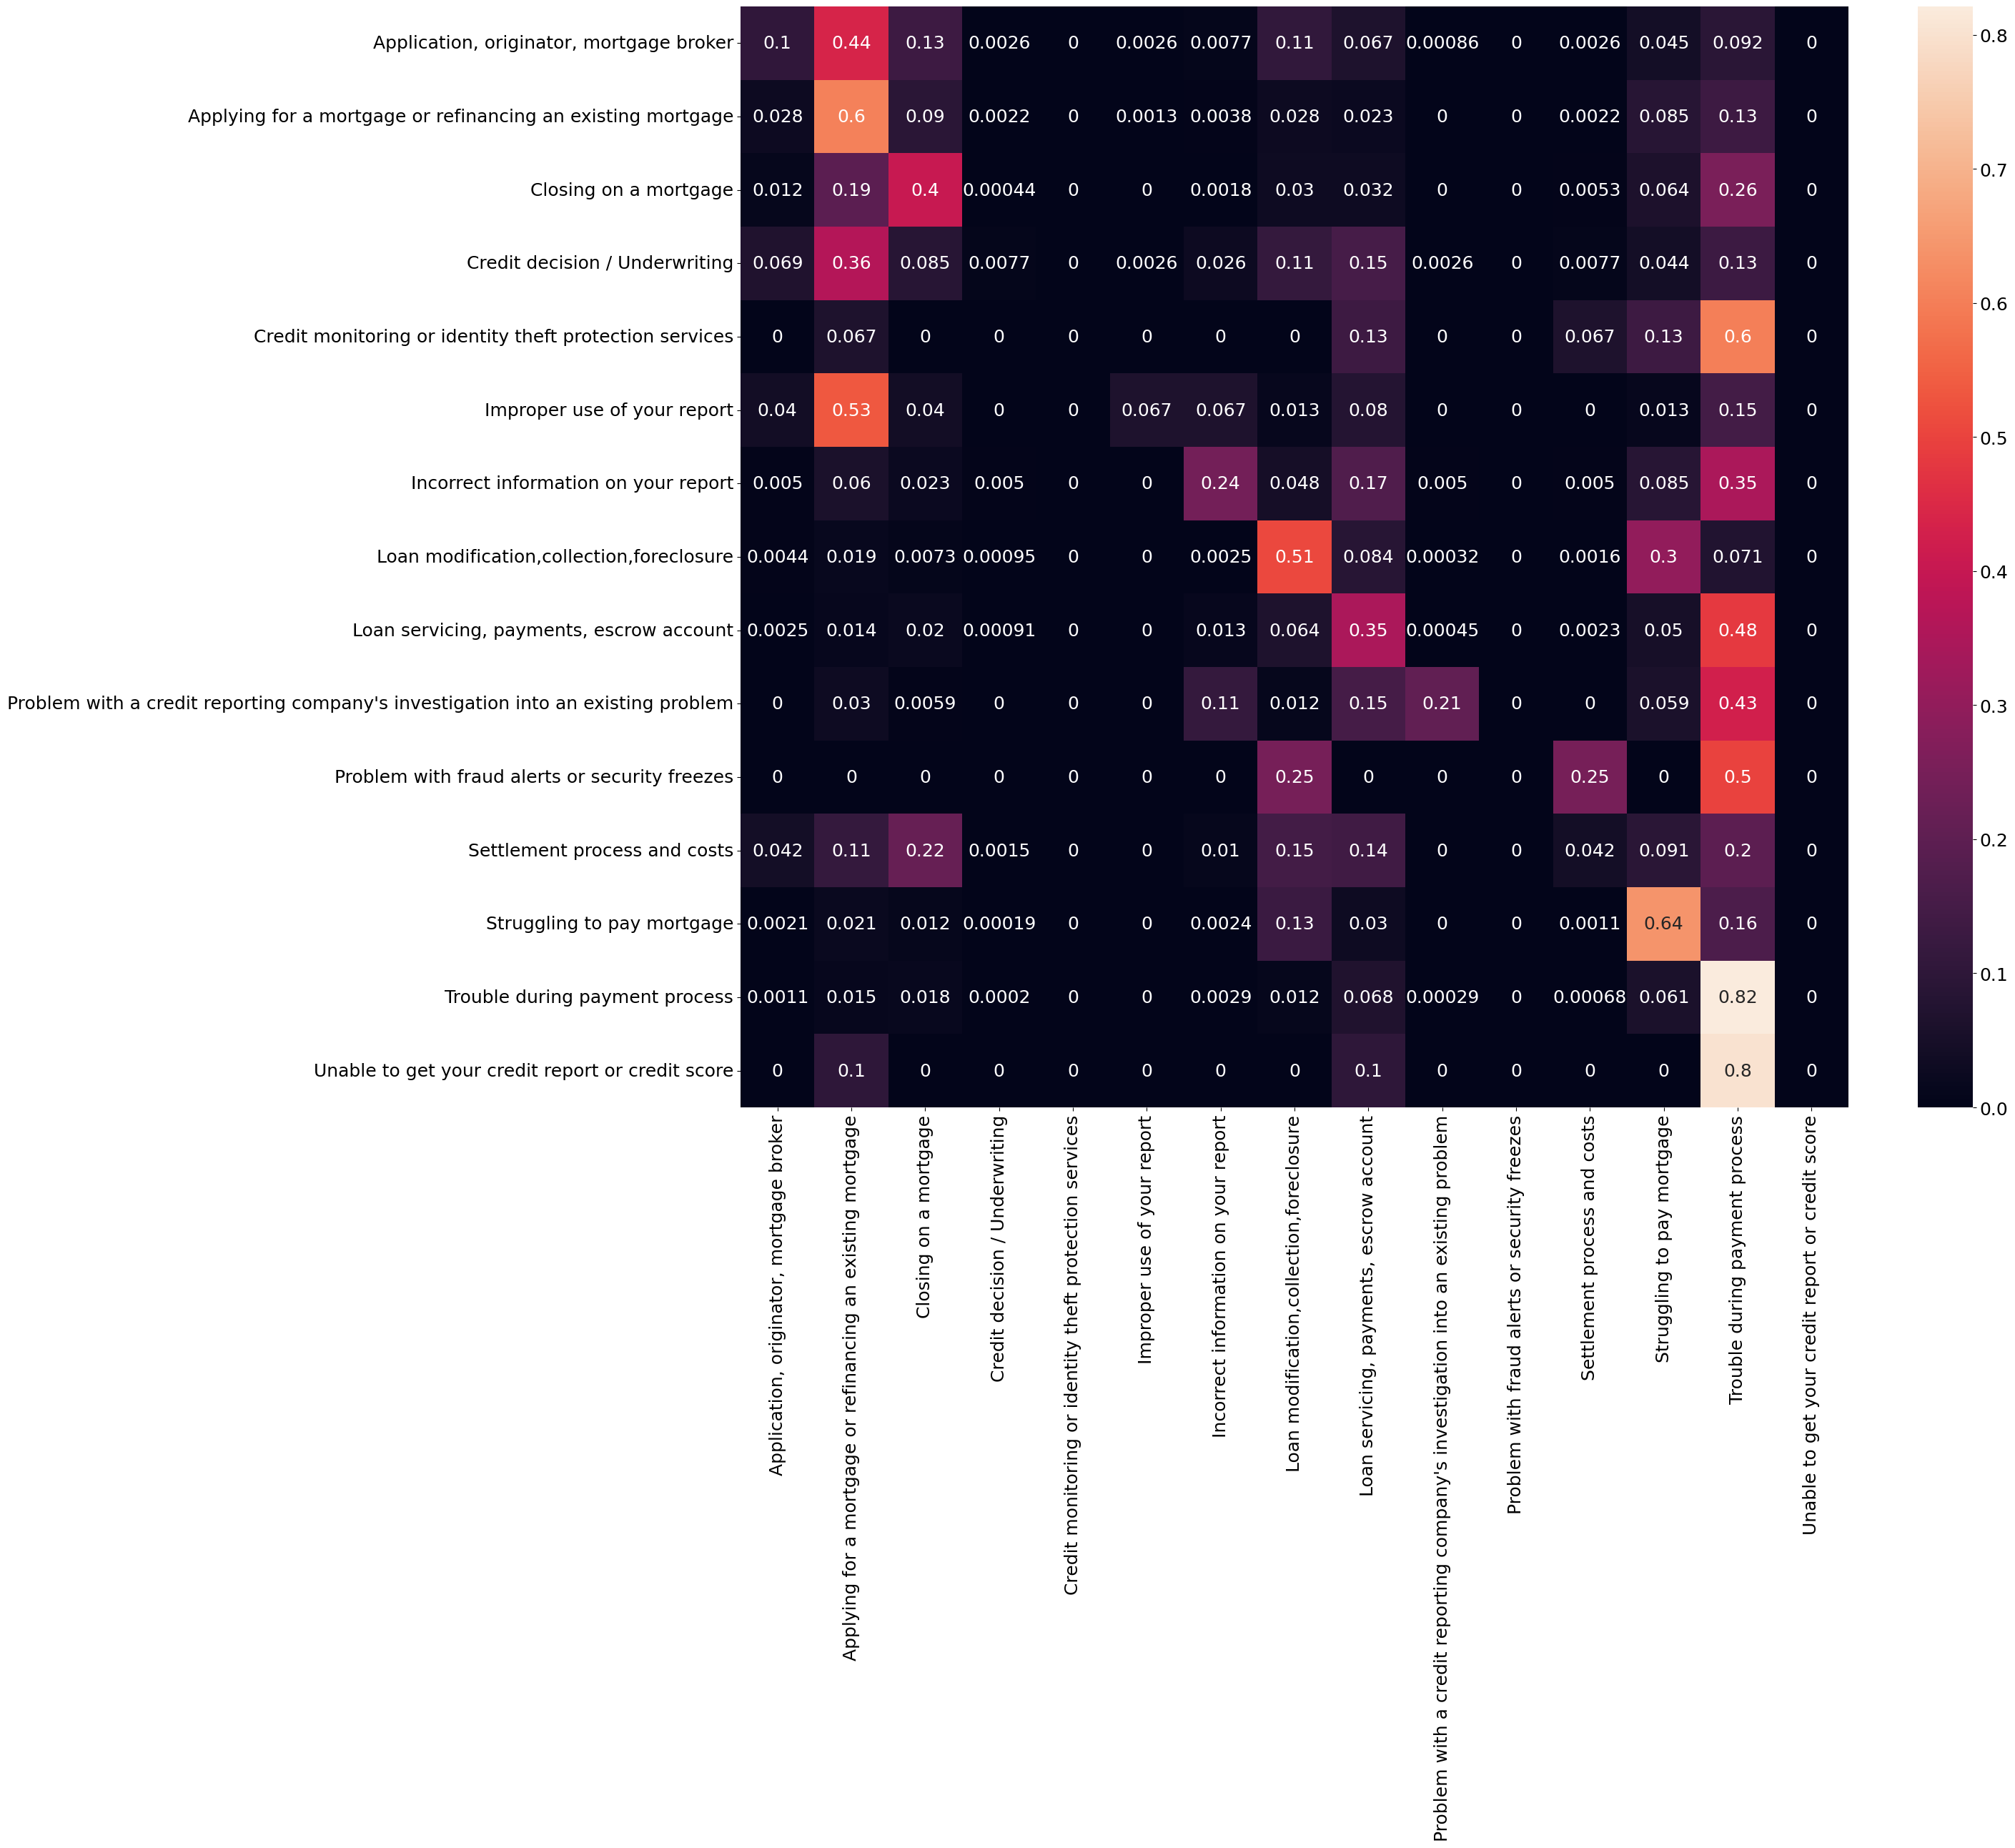

In [13]:
# Print scores
print(f"accuracy:{accuracy_score(y_test, y_pred)}")
print(f"f1 score:{f1_score(y_test, y_pred, average='weighted')}")

cm = pd.DataFrame(confusion_matrix(y_test, y_pred), columns=cat_issue, index=cat_issue)
cm = (cm.transpose()/cm.sum(axis=1)).transpose()

# Show confusion matrix as heatmap
plt.figure(figsize=(25, 20))
plt.rcParams.update({'font.size': 18})
sns.heatmap(cm, annot=True)
plt.show()

Note:<br>
- Rows are the Issues
- Columns are the predicted Issues

It is seen in the confusion matrix that 'Trouble during payment process' (0.82), 'Applying for a mortgage or refinancing an existing mortgage' (0.6), and 'Loan modification,collection,foreclosure' (0.51) are the most correct predicted Issues.
<br><br>
It is clear that a part of the complaints is wrongly predicted to the Issues 'Trouble during payment process' and 'Applying for a mortgage or refinancing an existing mortgage'. This is mainly because the Issue 'Trouble during payment process' has many values in the dataset. For the issue 'Applying for a mortgage or refinancing an existing mortgage' is seen that other Issues that have been predicted wrongly contain little data, roughly 75-2206.
<br><br>
Furthermore, it is seen that the issues 'Problem with a credit reporting company's investigation into an existing problem', 'Credit monitoring or identity theft protection services', and 'Unable to get your credit report or credit score' are 0% correctly predicted. There is a shortage of data values regarding the issues. That's why these couldn't be correctly predicted by the model.
<br><br>
The model scores can be improved if there are new complaints created regarding the issues that contain fewer data values. As the issues contain less than 1000 data values, the chances are bigger that these will be not correctly predicted. The following issues should have more data values to improve the model.
* Problem with a credit reporting company's investigation into an existing problem
* Improper use of your report
* Credit monitoring or identity theft protection services
* Unable to get your credit report or credit score
* Problem with fraud alerts or security freezes
<br><br>
f1 score is 0.5477... This means that the model is in general ok.<br>
The accuracy for this model is 0.5741... This means that 57% of the test data is predicted correctly.

In [20]:
# Print classification report
print(classification_report(y_test, y_pred, target_names=cat_issue, zero_division=0))

                                                                                  precision    recall  f1-score   support

                                        Application, originator, mortgage broker       0.35      0.10      0.16      1167
                     Applying for a mortgage or refinancing an existing mortgage       0.54      0.60      0.57      3159
                                                           Closing on a mortgage       0.48      0.40      0.44      2260
                                                  Credit decision / Underwriting       0.11      0.01      0.01       389
                         Credit monitoring or identity theft protection services       0.00      0.00      0.00        15
                                                     Improper use of your report       0.38      0.07      0.11        75
                                            Incorrect information on your report       0.36      0.24      0.29       399
                       

- Precision looks how many of the predicted issues are correct for each actual specific issue. (vertical - from confusionmatrix)
- Recall checks what percentage is correctly predicted from all predicted issues for the specific issue. (horizontal - from confusionmatrix)
- F1 score shows if the model does a good job with predicting the issues.

## Test model with a custom complaint

In [21]:
# Test the model with custom text
new_complaint = "My mortgage was sold to Roundpoint company in XX/XX/2023. I got a letter in XXXX from my prior lender, XXXX XXXX stating this was to occur and the next payment to be made would go to Roundpoint. But this is false. The information in the letter is not true. I think it is a mistake of yours"
new_complaint_vectorized = vectorizer.transform([new_complaint])
issue_pred = logregression.predict(new_complaint_vectorized)
print('Predicted issue:', issue_pred[0])

Predicted issue: Loan servicing, payments, escrow account


## Conclusion

To conclude, the Multinomial Logistic Regression model scores ok with the given data (f1 score is 0.5477). The accuracy of this model is 0.5741..., which is 57% that is correctly predicted.
<br><br>
Based of the classification report it is seen that the issues 'Trouble during payment process' (0.72), 'Struggling to pay mortgage' (0.61), and 'Applying for a mortgage or refinancing an existing mortgage' has the highest f1-score. This means that the model works the best for these issues. Besides, there are issues that has for the precision, recall, and f1-score a score of 0.00. The reason for this is that there is a shortage of data values regarding the issues. That's why these couldn't be correctly predicted by the model.
<br><br>
To improve the model, there must be more data created for some issues, as these issues contain less than 1000 values. The following issues should have more data values to improve the model:
* Problem with a credit reporting company's investigation into an existing problem
* Improper use of your report
* Credit monitoring or identity theft protection services
* Unable to get your credit report or credit score
* Problem with fraud alerts or security freezes

## GridSearch
Find the best parameters for this model

For the parameter solver, only saga and sag will be checked as they support large datasets.<br>
More information about the solvers: https://scikit-learn.org/stable/modules/linear_model.html#solvers

In [22]:
# print("creating gridsearch")
# param_grid = {
#     'C': [0.001, 0.01, 0.1, 1, 10, 100],
#     'solver': ['sag', 'saga'],
#     'max_iter': [100, 1000, 2500, 5000],
#     'penalty': ['l1', 'l2', 'elasticnet', None]
# }

# # Subselect the first 10000 samples for the GridSearch
# X_train_tfidf_subselect = X_train_tfidf[:10000]
# y_train_subselect = y_train[:10000]

# model = LogisticRegression(multi_class='multinomial', n_jobs=4, random_state=2)
# grid = GridSearchCV(model, param_grid, verbose=3)
# grid.fit(X_train_tfidf_subselect, y_train_subselect)
# print(grid.best_params_)
# print(grid.best_estimator_)
# print(grid.best_score_)

* After fitting the gridsearch with the logistic regression it is clear that {'C': 1, 'max_iter': 100, 'penalty': 'l2', 'solver': 'saga'} the best parameters for the model is.<br>
* The best estimators for the LogisticRegression is the following:<br>LogisticRegression(C=1, multi_class='multinomial', n_jobs=4, random_state=2, solver='saga')
* The best score is 0.5269